# Colorimetric Chain Evaluation Tool

This template allows to evaluate the quality of a colorimetric chain given input and output images with Full Reference Quality Assessment (FR-IQA) tools and spectra analysis.

In [1]:
#%matplotlib inline
import sys
sys.path.append('../')
from colorimetryevaluation import *

## Data

This first section is only to load the inputs and outputs of the colorimetric chain. Depending on what you want to test, you will need to provide various types of data.  

For instance:
- if you are simply willing to evaluate the distortion you can use any image
- if you are willing to evaluate difference of gamuts between input and output a colormap is more accurate
- if you are willing to look for banding artifacts you can use a black and white gradient as splash input

In order to be compared, input and output images must be of same size. The first function simply loads and plots the input and output images from files.

**Syntax:** ```loadImages(input_file: str = 'data/input.jpeg', output_file: str = 'data/output.jpg', plot_images: bool = True)```

    Loads and plots images if images are of same shape 
    args:
        - input_file: path to input image
        - output_file: path to output image
        - plot_image: plot if true
    returns:
        - input_image: numpy.ndarray
        - output_image: numpy.ndarray
    raises:
        - Runtime Error: if images are not of the same size

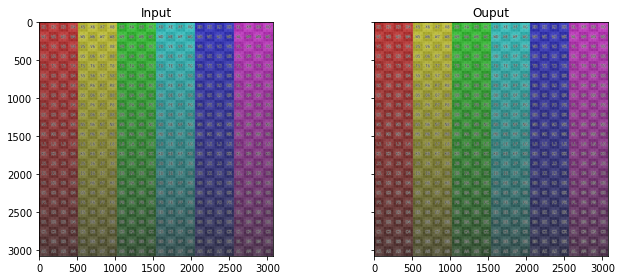

In [2]:
input_image, output_image = loadImages('../Data/input.png','../Data/output.png')

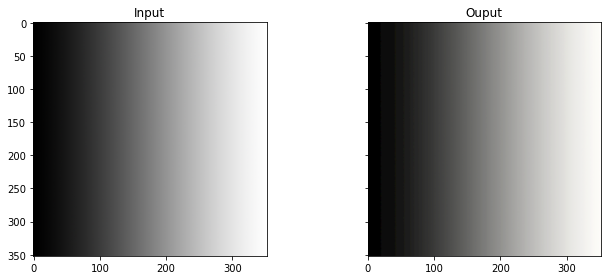

In [3]:
input_gradient, output_gradient = loadImages('../Data/input_gradient.png','../Data/output_gradient.png')

## Evaluation of the data
### Full Reference Image Quality Assessment

**Full Reference Image Quality Assessment (FR-IQA)** methods are objective quality assessment methods of an image (splash's output) with a reference image that is assumed to have perfect quality (splash's input).  

- The simplest and most widely used full-reference quality metric is the Mean Squared Error (MSE) along with the related quantity of Peak Signal-to-Noise Ratio (PSNR). These are appealing because they are simple to calculate, have clear physical meanings, and are mathematically convenient in the context of optimization.  
- But they are not very well matched to perceived visual quality, other indices such as Structural SIMilarity (SSIM) of Gradient Magnitude Similarity Deviation (GMSD) are perception-driven IQA models.  

#### SSIM 

**Theory:**  

In order to know the structural information in an image we wish to separate the influence of luminance and contrast that can vary accross a scene. We then have three indices which combined give the **similarity measure**: 
 - Luminance comparison function $l(x,y)$ a function of $\mu_x$ and $\mu_y$
 - Contrast comparison function $c(x,y)$ a function of $\sigma_x$ and $\sigma_y$
 - Structure comparison $s(x,y)$ is done on the normalized signals $\frac{(x - \mu_x)}{\sigma_x}$ and $\frac{(y - \mu_y)}{\sigma_y}$

With 
- $\mu_x = \frac{1}{N} \Sigma _{i=1} ^N x_i$  
- $\sigma_x = (\frac{1}{N-1}\Sigma_{i=1}^N (x_i - \mu_x)^2)^{\frac{1}{2}}$

We then define the overall similarity measure  
$$S(x,y)=f(l(x,y),c(x,y),s(x,y))$$

and we want this function to verify
- Symmetry $S(x,y) = S(y,x)$
- Boundedness $S(x,y) \leq 1$
- Unique Maximum $S(x,y)=1$ if and only if $x=y$

Then to evaluate the overall image quality we use a mean SSIM (MSSIM) index defined as followed

$$MSSIM(X,Y)=\frac{1}{M}\Sigma_{j=1}^M SSIM(x_j,y_j)$$

**Interpretation:**  

In the map, the brighter the gray level, the lower the similarity, and thus the higher the predicted local quality. 

The smaller the index, the lower the distortion range. If the index is equal to 1 there is no distorsion at all (images are equal).

**Syntax:** ```SSIM(input_image, output_image, plot_fig: bool = True, save_fig: bool = False, display_mode: DisplayMode = DisplayMode.SingleGreyScale)```


    Multichannel SSIM, computes and plots SSIM index and map
    args:
        - input_image: numpy.ndarray
        - output_image: numpy.ndarray
        - plot_image: plot if true
        - save_fig: save the plot if true
        - display_mode: mode to display the ssim map
    returns:
        - ssim_index: float
        - ssim_map: numpy.ndarray

>  Similarity calculations are done independently for each channel, then there are 3 different display modes:
- ```DisplayMode.SingleGreyScale```:  Similarity calculations of each channel are averaged. It may be useful to have an overall idea of the quality of the output, but lacks the color information.
- ```DisplayMode.SingleRGB```: The 3 channels are plotted on the same rgb map. It contains the color information but may be difficult to read.
- ```DisplayMode.ChannelBychannel```: The 3 channels are plotted on three different maps.

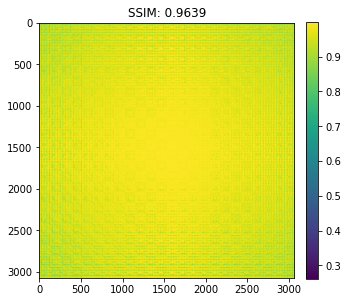

<Figure size 432x288 with 0 Axes>

In [4]:
ssim_index, ssim_map = SSIM(input_image,output_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


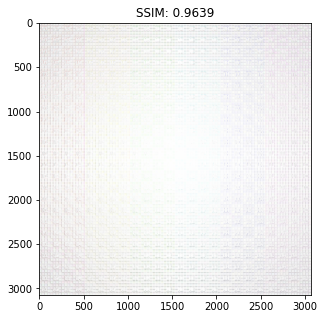

<Figure size 432x288 with 0 Axes>

In [5]:
ssim_index, ssim_map = SSIM(input_image,output_image, display_mode = DisplayMode.SingleRGB)

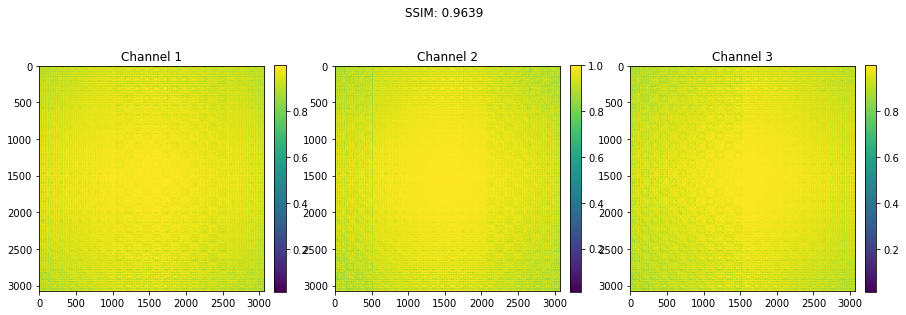

<Figure size 432x288 with 0 Axes>

In [6]:
ssim_index, ssim_map = SSIM(input_image,output_image,  display_mode = DisplayMode.ChannelBychannel)

#### GMSD

**Theory:**  

For digital images, the gradient magnitude is defined as the root mean square of image directional gradients along two orthogonal directions. The gradient is usually computed by convolving an image with a linear filter.

$h_x = \begin{bmatrix} 
\frac{1}{3} && 0 && -\frac{1}{3} \\
\frac{1}{3} && 0 && -\frac{1}{3} \\
\frac{1}{3} && 0 && -\frac{1}{3} \\ 
\end{bmatrix}$  
$h_y = \begin{bmatrix} 
\frac{1}{3} && \frac{1}{3} && \frac{1}{3} \\
0 && 0 && 0 \\
-\frac{1}{3} && -\frac{1}{3} && -\frac{1}{3} \\ 
\end{bmatrix}$  

The gradient magnitude of $r$ and $d$ at location $i$ are computed as followed: 

$m_r(i) = \sqrt{(r \otimes h_x)² (i) + (r \otimes h_y)² (i)}$  
$m_d(i) = \sqrt{(d \otimes h_x)² (i) + (d \otimes h_y)² (i)}$ 

where $\otimes$ denotes the convolution operation

The Gradient magniture similarity (GMS) map is computed as follows:

$$GMS(i) = \frac{2m_r(i)m_d(i)+c}{m_r²(i)+m_d²(i)+c}$$

where $c$ is a positive constant that supplies numerical stability 

$GMSM = \frac{1}{N} \Sigma _{i=1}^N GMS(i)$

The final IQA index, namely **Gradient Magnitude Similarity Deviation (GMSD)**:

$$GMSD = \sqrt{\frac{1}{N} \Sigma _{i=1}^N (GMS(i)-GMSM)²}$$

**Interpretation:**  

In the GMS map, the brighter the gray level, the higher the similarity, and thus the higher the predicted local quality.  

The value of GMSD reflects the range of distortion severities in an image. The higher the GMSD score, the larger the distortion range, and thus the lower the image perceptual quality.

**Syntax:** ```GMSD(input_image, output_image, plot_fig: bool = True, save_fig: bool = False, display_mode: DisplayMode = DisplayMode.SingleGreyScale)```

    Computes and plots GMSD index and map channel by channel
    args:
        - input_image: numpy.ndarray
        - output_image: numpy.ndarray
        - plot_image: plot if true
        - save_fig: save the plot if true
        - display_mode: mode to display the gmds map
    returns:
        - gmsd_index: float
        - gmsd_map: numpy.ndarray

>  Similarity calculations are done independently for each channel, then there are 3 different display modes:
- ```DisplayMode.SingleGreyScale```:  Similarity calculations of each channel are averaged. It may be useful to have an overall idea of the quality of the output, but lacks the color information.
- ```DisplayMode.SingleRGB```: The 3 channels are plotted on the same rgb map. It contains the color information but may be difficult to read.
- ```DisplayMode.ChannelBychannel```: The 3 channels are plotted on three different maps.

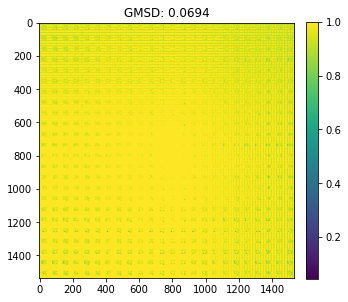

<Figure size 432x288 with 0 Axes>

In [7]:
gmsd_index, gmsd_map = GMSD(input_image,output_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


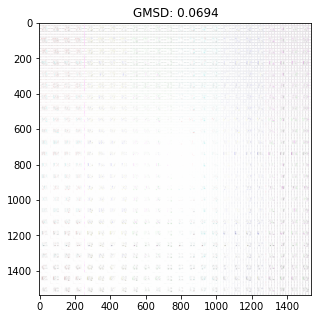

<Figure size 432x288 with 0 Axes>

In [8]:
gmsd_index, gmsd_map = GMSD(input_image, output_image, display_mode = DisplayMode.SingleRGB)

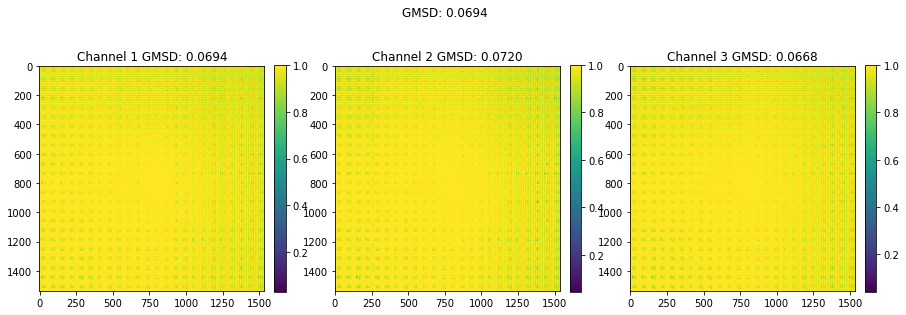

<Figure size 432x288 with 0 Axes>

In [9]:
gmsd_index, gmsd_map = GMSD(input_image, output_image, display_mode = DisplayMode.ChannelBychannel)

**Comment:**  

Not bad, could do better (at least way better than ssim)

#### Non perceptual indices

**Mean Square Error (MSE)** computed by averaging the squared intensity differences of distorted and reference image pixels

**Peak signal-to-noise ratio (PSNR)** is an engineering term for the ratio between the maximum possible power of a signal and the power of corrupting noise that affects the fidelity of its representation. [Wikipedia](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)

In [10]:
mse_index = mse(input_image,output_image)
psnr_index = psnr(input_image,output_image)

print(f'MSE: {mse_index:.4f}, PSNR: {psnr_index:.2f}')

MSE: 0.0013, PSNR: 28.79


**Comment:**  

### Spectral analysis

Three different types of spectra are computed from FFT in this section.

- **Power spectrum** shows any periodic structure in the original spatial-domain image that will be represented by a peak at a radius corresponding to the spacing and a direction corresponding to the orientation. 
- **Magnitude spectrum** tells you how strong are the harmonics in a image.
- **Phase spectrum** tells where this harmonic lies in space.


In a real image, which typically consists of mostly non-periodic information, any such peaks will be superimposed on a broad and sometimes noisy background. Finding the peaks is generally much easier than finding the original periodic structure.
Also, measuring the peak locations accurately is much easier and more accurate than trying to extract the same information from the original image, because all of the occurrences are effectively averaged together in the frequency domain.

The first function computes and plots the spectra of both input and output images

**Syntax:** ```inputOutputSpectra(input_image, output_image, spectra: Spectra = Spectra.Power, plot_fig: bool = True, save_fig: bool = False, multichannel: bool = True)```

    PLots the fourier transform of multichannel images
    args:
        - input_image: numpy.ndarray
        - output_image: numpy.ndarray
        - spectra: type of spectra (power, magnitude, phase)
        - plot_image: plot if true
        - save_fig: save the plot if true
    returns:
        - input_spectrum: np.ndarray
        - output_spectrum: np.ndarray
        
It can be more interesting to compute the spectrum of the difference of the two images to enhance periodic artefacs that can appear with banding for instance.

**Syntax:** ```differenceSpectrum(input_image, output_image, spectra: Spectra = Spectra.Power, plot_fig: bool = True, save_fig: bool = False, multichannel: bool = True)```

    PLots the fourier transform of the difference of multichannel images
    args:
        - input_image: numpy.ndarray
        - output_image: numpy.ndarray
        - spectra: type of spectra (power, magnitude, phase)
        - plot_image: plot if true
        - save_fig: save the plot if true
    returns:
        - spectrum: np.ndarray spectrum of the difference
        

**Power Spectrum**

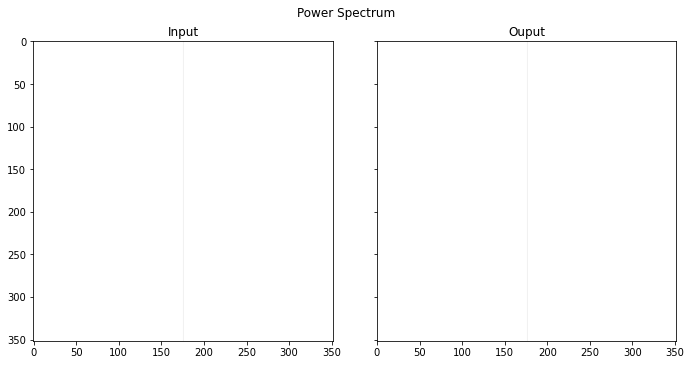

<Figure size 432x288 with 0 Axes>

In [11]:
input_spectrum, output_spectrum = inputOutputSpectra(input_gradient, output_gradient, Spectra.Power)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


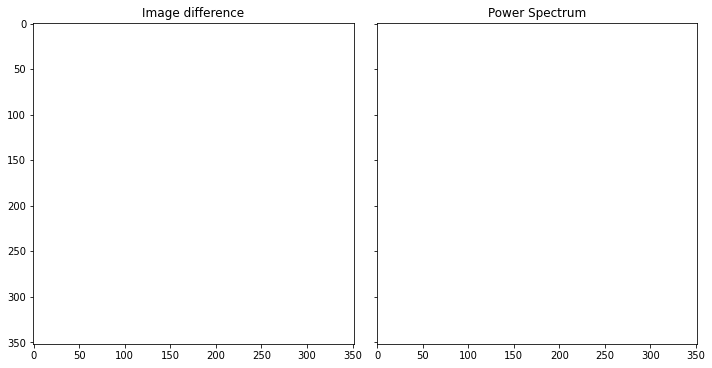

<Figure size 432x288 with 0 Axes>

In [12]:
spectrum = differenceSpectrum(input_gradient, output_gradient, Spectra.Power)

**Phase Spectrum**

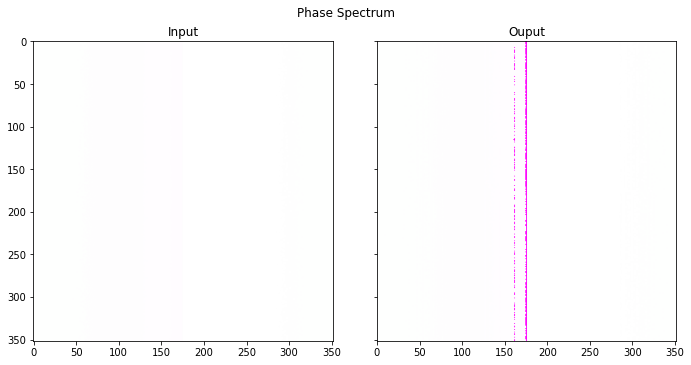

<Figure size 432x288 with 0 Axes>

In [13]:
input_spectrum, output_spectrum = inputOutputSpectra(input_gradient, output_gradient, Spectra.Phase)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


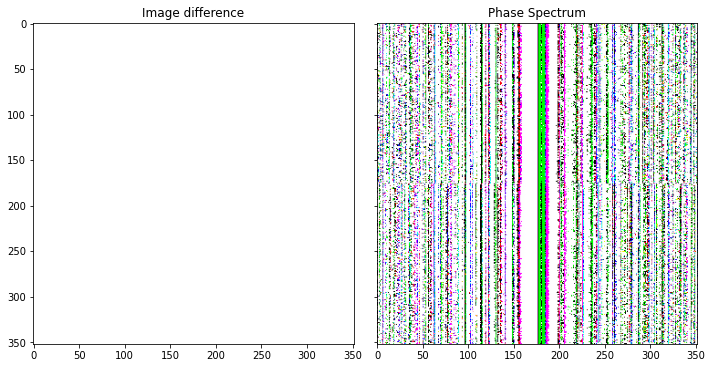

<Figure size 432x288 with 0 Axes>

In [14]:
spectrum = differenceSpectrum(input_gradient, output_gradient, Spectra.Phase)

**Magnitude Spectrum**

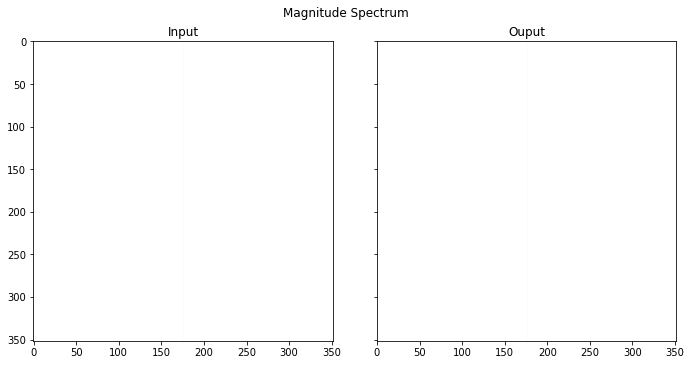

<Figure size 432x288 with 0 Axes>

In [15]:
input_spectrum, output_spectrum = inputOutputSpectra(input_gradient, output_gradient, Spectra.Magnitude)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


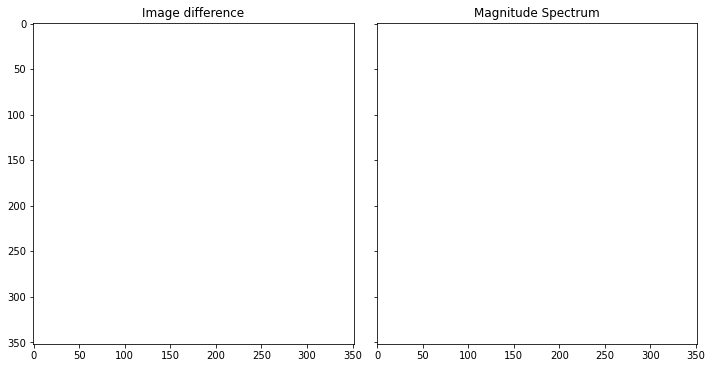

<Figure size 432x288 with 0 Axes>

In [16]:
spectrum = differenceSpectrum(input_gradient, output_gradient, Spectra.Magnitude)

#### Little guide for spectral analysis

Banding adds a periodic distorsion that may be easier to see on a spectrum than on the image itself. In order to illustrate this we simulate banding on a black gradient with different precision.

In [18]:
higher_def = np.ones((32,32))
medium_def = np.ones((32,32))
lower_def = np.ones((32,32))

for i in range (32):
    
    higher_def[:,i] *= 8*i
    medium_def[:,i] *= 16*(i//2)
    lower_def[:,i] *= 24*(i//3)

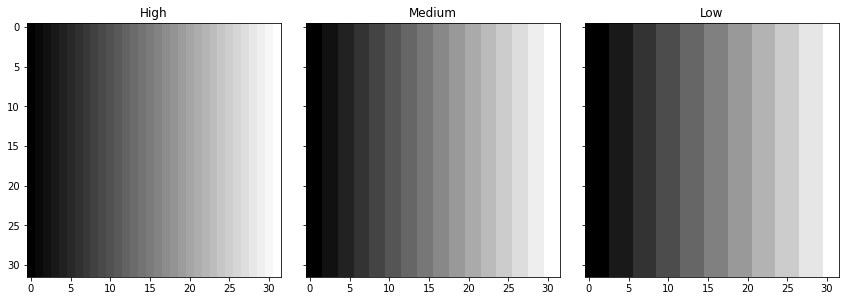

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4),
                         sharex=True, sharey=True)

axes[0].imshow(higher_def,cmap='gray')
axes[0].set_title('High')
axes[1].imshow(medium_def,cmap='gray')
axes[1].set_title('Medium')
axes[2].imshow(lower_def,cmap='gray')
axes[2].set_title('Low')

plt.tight_layout()
        
plt.show()

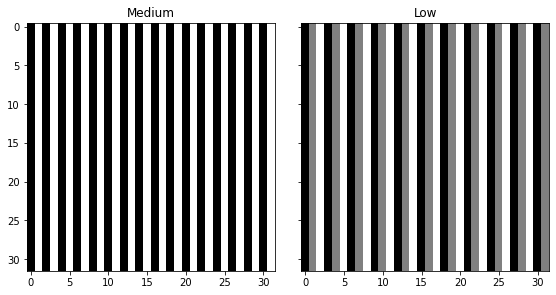

In [20]:
diff_medium = higher_def - medium_def
diff_lower = higher_def - lower_def

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

axes[0].imshow(diff_medium,cmap='gray')
axes[0].set_title('Medium')
axes[1].imshow(diff_lower,cmap='gray')
axes[1].set_title('Low')

plt.tight_layout()
        
plt.show()

On the diffence between the two images the periocity of the distorsion appears clearly with the presence of vertical stripes. On this example it is quite obvious but on more sublte real-life cases it may be easier to enhance this periodicity with the help of spectra analysis.

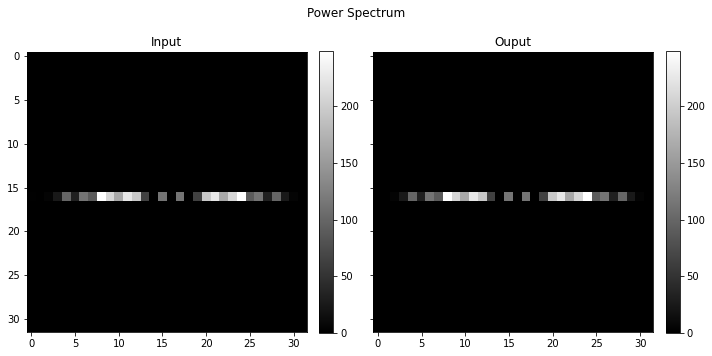

<Figure size 432x288 with 0 Axes>

In [21]:
higher_spectrum, medium_spectrum = inputOutputSpectra(higher_def, medium_def, Spectra.Power, multichannel=False)

Here the gradient is in only one direction so the usefull piece of information is contained in the the middle row.

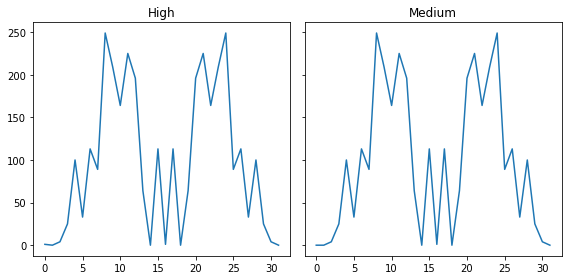

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

axes[0].plot(higher_spectrum[16])
axes[0].set_title('High')
axes[1].plot(medium_spectrum[16])
axes[1].set_title('Medium')

plt.tight_layout()
        
plt.show()

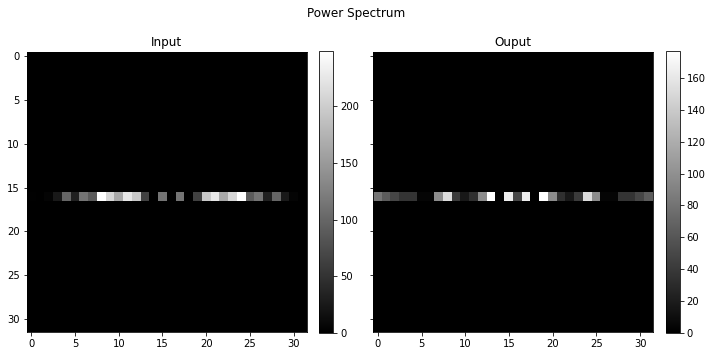

<Figure size 432x288 with 0 Axes>

In [23]:
higher_spectrum, lower_spectrum = inputOutputSpectra(higher_def, lower_def, Spectra.Power, multichannel=False)

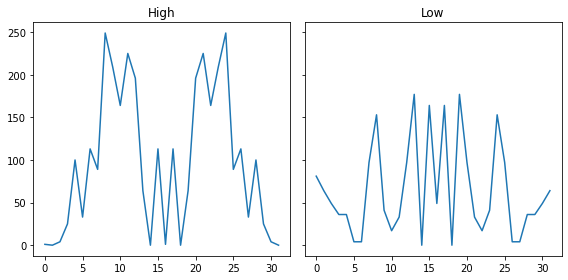

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

axes[0].plot(higher_spectrum[16])
axes[0].set_title('High')
axes[1].plot(lower_spectrum[16])
axes[1].set_title('Low')

plt.tight_layout()
        
plt.show()

It may be difficult to see the difference of the two spectra, on the first one it is not really obvious, on the second one the difference is more visible with more high frequencies and less amplitude on low frequencies on the second image.

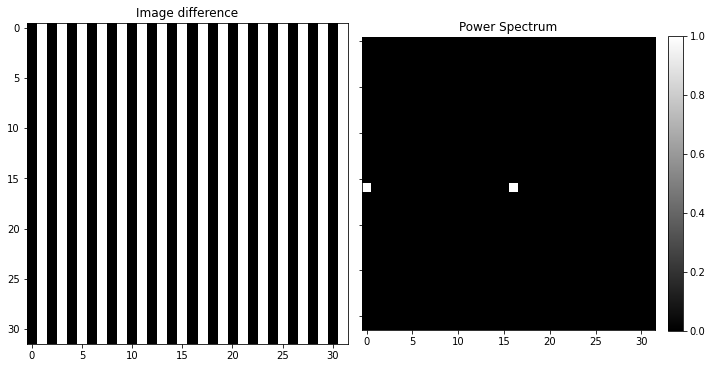

<Figure size 432x288 with 0 Axes>

In [25]:
medium_diff_spectrum = differenceSpectrum(higher_def, medium_def, Spectra.Power, multichannel=False)

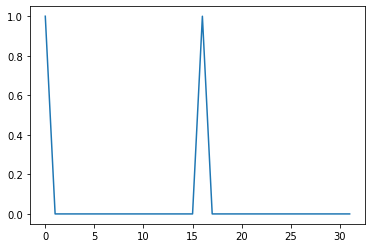

In [26]:
plt.plot(medium_diff_spectrum[16])

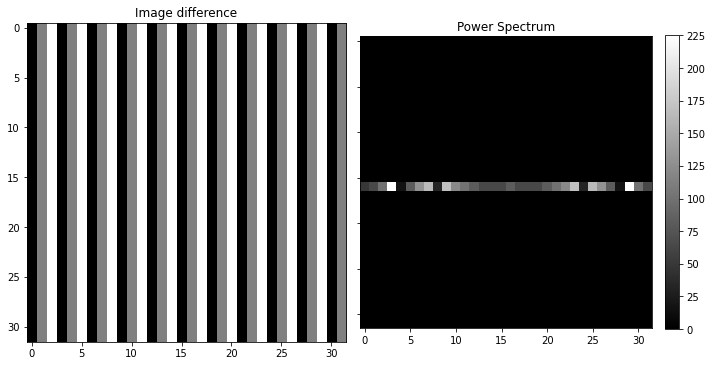

<Figure size 432x288 with 0 Axes>

In [27]:
lower_diff_spectrum = differenceSpectrum(higher_def,lower_def,Spectra.Power,multichannel=False)

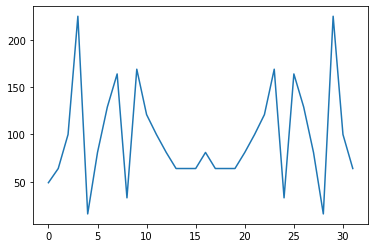

In [28]:
plt.plot(lower_diff_spectrum[16])

The difference is more visible on the spectrum of the difference between the two images:  
1 - One central peak  
2 - Several peaks mainly located on the edges

> **Important note:**  
If gradient are of same precision but with slightly shifted values, the difference between the two images might be the same as the difference with two gradients with different precision as shown below. In this case comparing input and output spectra might useful.

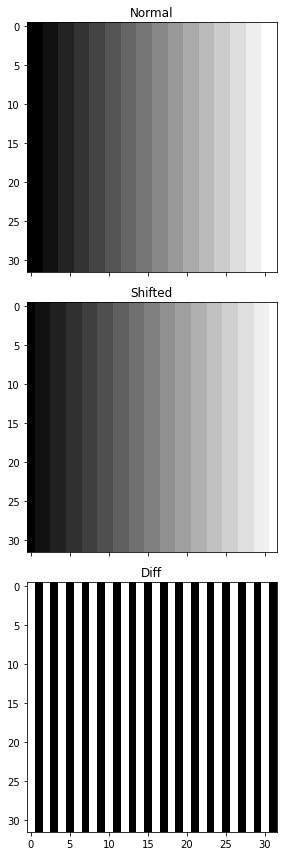

In [29]:
ref = np.ones((32,32))
shifted = np.ones((32,32))

for i in range (32):
    
    ref[:,i] *= 16*(i//2)
    shifted[:,i] *= 16*((i+1)//2)


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(4, 12),
                         sharex=True, sharey=True)

axes[0].imshow(ref,cmap='gray')
axes[0].set_title('Normal')
axes[1].imshow(shifted,cmap='gray')
axes[1].set_title('Shifted')
axes[2].imshow(ref - shifted,cmap='gray')
axes[2].set_title('Diff')

plt.tight_layout()
        
plt.show()

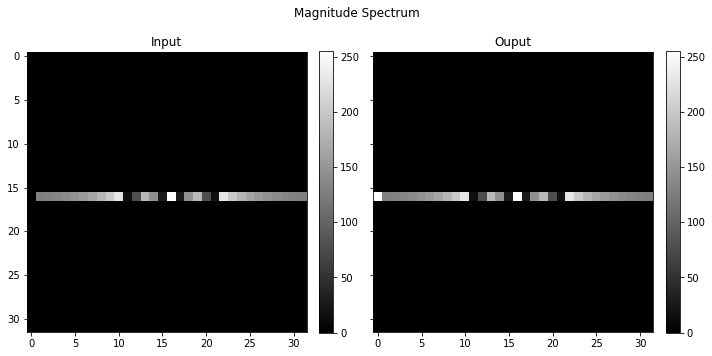

<Figure size 432x288 with 0 Axes>

In [30]:
ref_magnitude_spectrum, shifted_magnitude_spectrum = inputOutputSpectra(ref, shifted, Spectra.Magnitude, 
                                                                        multichannel=False)

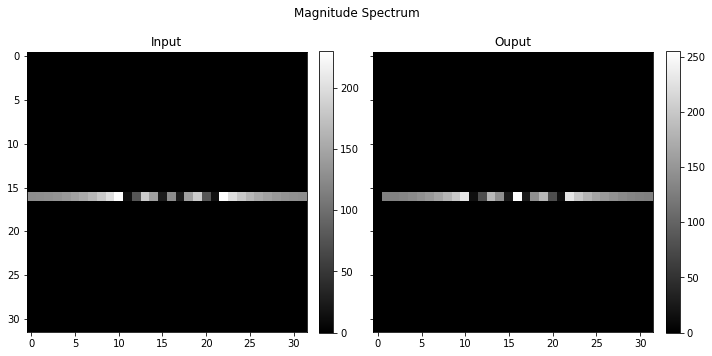

<Figure size 432x288 with 0 Axes>

In [31]:
higher_spectrum, medium_spectrum = inputOutputSpectra(higher_def, medium_def, Spectra.Magnitude, multichannel=False)